# Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Reading Data

In [2]:
# Detecting the encoding
with open('spam.csv', 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']
print(f'Detected encoding: {encoding}')

# Read the CSV with the detected encoding
df = pd.read_csv('spam.csv', encoding=encoding)

Detected encoding: Windows-1252


In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

In [7]:
df.isna().sum()

v1    0
v2    0
dtype: int64

# Exploratory Data Analysis

In [8]:
df1=df

In [9]:
df['v1'] = df['v1'].map({'ham': 0, 'spam': 1})

In [10]:
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(403)

In [13]:
df_duplicate=df[df.duplicated()] # Finding duplicate rows

In [14]:
df_duplicate.head(10)

,v1,v2
102,0,As per your request 'Melle Melle (Oru Minnamin...
153,0,As per your request 'Melle Melle (Oru Minnamin...
206,0,"As I entered my cabin my PA said, '' Happy B'd..."
222,0,"Sorry, I'll call later"
325,0,No calls..messages..missed calls
338,0,"Sorry, I'll call later"
356,1,Congratulations ur awarded 500 of CD vouchers ...
443,0,"Sorry, I'll call later"
532,0,Gudnite....tc...practice going on
654,0,Did u got that persons story


C:\Users\adrij\AppData\Local\Temp\ipykernel_31308\4222274297.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dup_counts.index, y=dup_counts.values, palette='viridis')


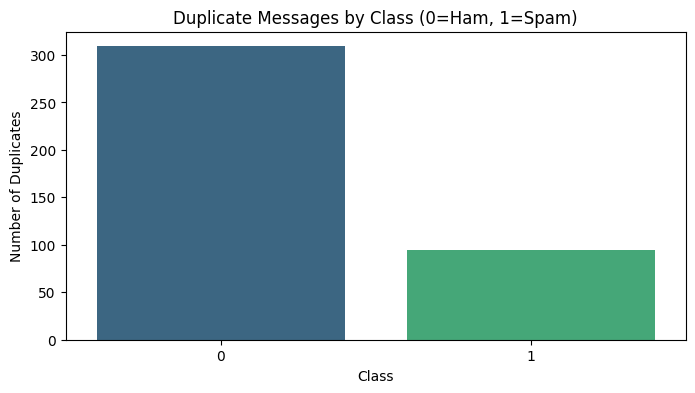

In [15]:
# Counting duplicates by label
dup_counts = df_duplicate['v1'].value_counts()

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=dup_counts.index, y=dup_counts.values, palette='viridis')
plt.title('Duplicate Messages by Class (0=Ham, 1=Spam)')
plt.xlabel('Class')
plt.ylabel('Number of Duplicates')
plt.show()

In [16]:
# Checking if duplicates have conflicting labels (same message but different labels)
conflicts = df.groupby('v2')['v1'].nunique().sort_values(ascending=False)
conflicting_messages = conflicts[conflicts > 1].index.tolist()

if conflicting_messages:
    print(f"Found {len(conflicting_messages)} messages with conflicting labels.")
else:
    print("No conflicting labels in duplicates. Safe to drop duplicates.")

# Remove duplicates (keep first occurrence)
df_clean = df.drop_duplicates(subset=['v2'], keep='first')
print(f"Original shape: {df.shape}, Cleaned shape: {df_clean.shape}")

No conflicting labels in duplicates. Safe to drop duplicates.
Original shape: (5572, 2), Cleaned shape: (5169, 2)


In [17]:
df_clean.duplicated().sum()

np.int64(0)

In [18]:
df_clean['v1'].value_counts()

v1
0    4516
1     653
Name: count, dtype: int64

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adrij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
df_clean['num_characters']=df_clean['v2'].apply(len)

C:\Users\adrij\AppData\Local\Temp\ipykernel_31308\3451655050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['num_characters']=df_clean['v2'].apply(len)


In [21]:
df_clean.head()

,v1,v2,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
df_clean['num_words']=df['v2'].apply(lambda x:len(nltk.word_tokenize(x)))

C:\Users\adrij\AppData\Local\Temp\ipykernel_31308\3063606196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['num_words']=df['v2'].apply(lambda x:len(nltk.word_tokenize(x)))


In [23]:
df_clean.head()

,v1,v2,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [24]:
df_clean['num_sentences']=df_clean['v2'].apply(lambda x:len(nltk.sent_tokenize(x)))

C:\Users\adrij\AppData\Local\Temp\ipykernel_31308\2696789181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['num_sentences']=df_clean['v2'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [25]:
df_clean.head()

,v1,v2,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [26]:
df_clean[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [27]:
df_clean[df_clean['v1']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [28]:
df_clean[df_clean['v1']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

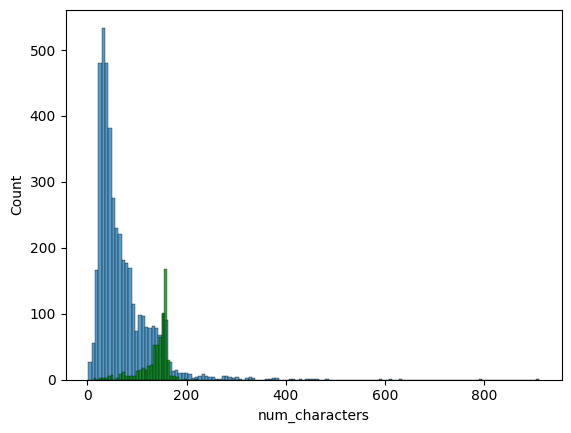

In [29]:
sns.histplot(df_clean[df_clean['v1']==0]['num_characters'])
sns.histplot(df_clean[df_clean['v1']==1]['num_characters'],color='green')

In [30]:
numeric_columns = df_clean.select_dtypes(include='number')

<Axes: >

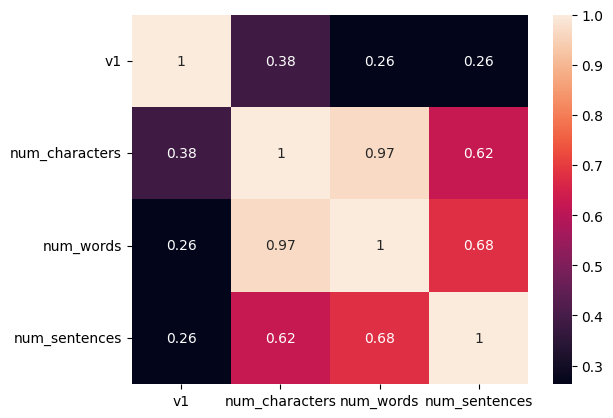

In [31]:
sns.heatmap(numeric_columns.corr(),annot=True)

 We see that there is a strong correlation between the number of characters, number of words and number of sentence

# Data Preprocessing

In [32]:
ps=PorterStemmer()

In [33]:
def transform_text(text):
    text=text.lower()
    text=nltk.word_tokenize(text)
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [34]:
df_clean['transformed_text']=df_clean['v2'].apply(transform_text)

C:\Users\adrij\AppData\Local\Temp\ipykernel_31308\2249401839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['transformed_text']=df_clean['v2'].apply(transform_text)


In [35]:
df_clean.head()

,v1,v2,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [36]:
wc=WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [37]:
spam_wc=wc.generate(df_clean[df_clean['v1']==1]['transformed_text'].str.cat(sep=" "))

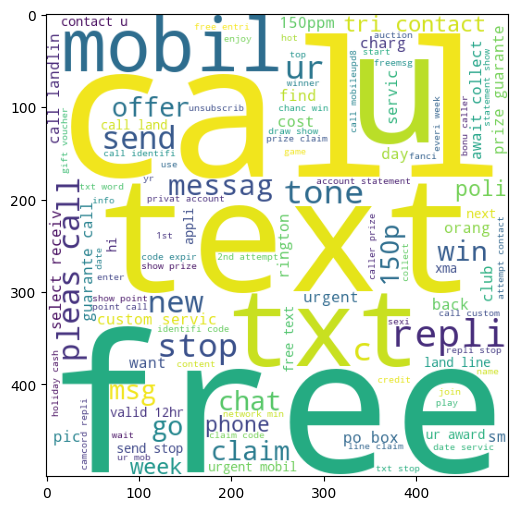

In [38]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [39]:
ham_wc=wc.generate(df_clean[df_clean['v1']==0]['transformed_text'].str.cat(sep=" "))

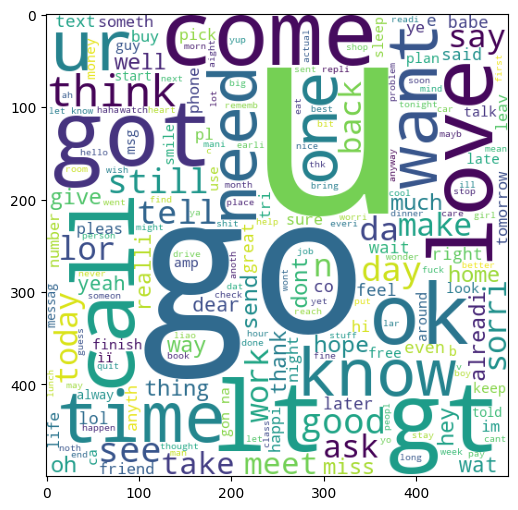

In [40]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [41]:
spam_corpus=[]
for msg in df_clean[df_clean['v1']==1]['transformed_text'].to_list():
    for words in msg.split():
        spam_corpus.append(words)


In [42]:
#spam_corpus

In [43]:
#len(spam_corpus)

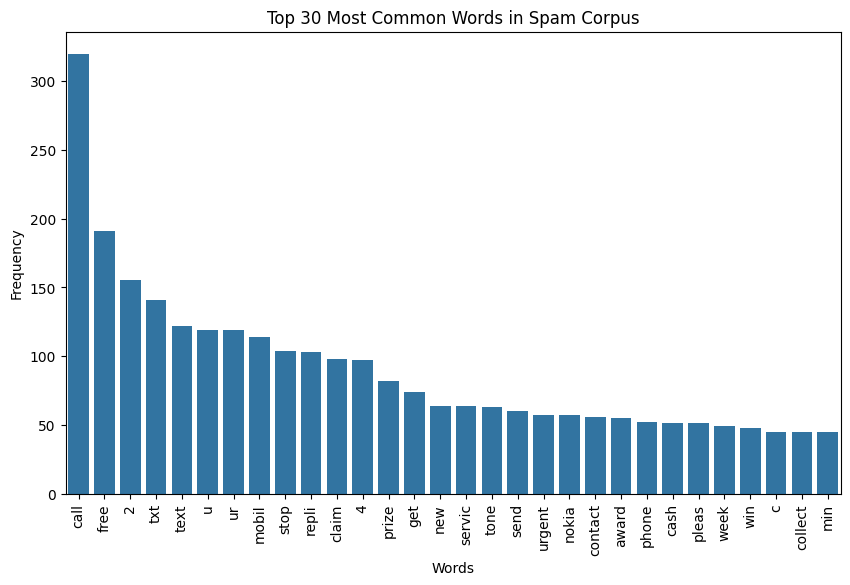

In [44]:
word_counts = Counter(spam_corpus)
top_words = [word[0] for word in word_counts.most_common(30)]
word_frequencies = [word[1] for word in word_counts.most_common(30)]
df_top_words = pd.DataFrame({'Word': top_words, 'Frequency': word_frequencies})

plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=df_top_words)
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Spam Corpus')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [45]:
ham_corpus=[]
for msg in df_clean[df_clean['v1']==0]['transformed_text'].to_list():
    for words in msg.split():
        ham_corpus.append(words)


In [46]:
# ham_corpus

In [47]:
# len(ham_corpus)

In [48]:
df_clean.head()

,v1,v2,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


# Model Training

In [49]:
# Split data
X = df_clean[['transformed_text', 'num_words']]
y = df_clean['v1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [50]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
scaler = MinMaxScaler()  


X_train_text = tfidf.fit_transform(X_train['transformed_text'])
X_test_text = tfidf.transform(X_test['transformed_text'])

In [51]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], 
                yticklabels=['Ham', 'Spam'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


MultinomialNB Performance:
Accuracy: 0.9691
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       903
           1       0.95      0.80      0.87       131

    accuracy                           0.97      1034
   macro avg       0.96      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



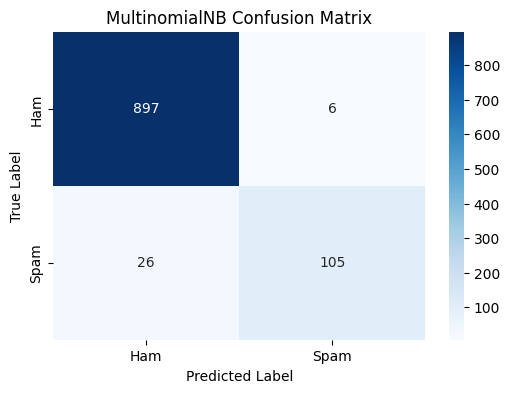

In [52]:
# Multinomial Naive Bayes
mnb=MultinomialNB()
mnb.fit(X_train_text,y_train)
evaluate_model(mnb, X_test_text, y_test, "MultinomialNB")


BernoulliNB Performance:
Accuracy: 0.9836
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       1.00      0.87      0.93       131

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



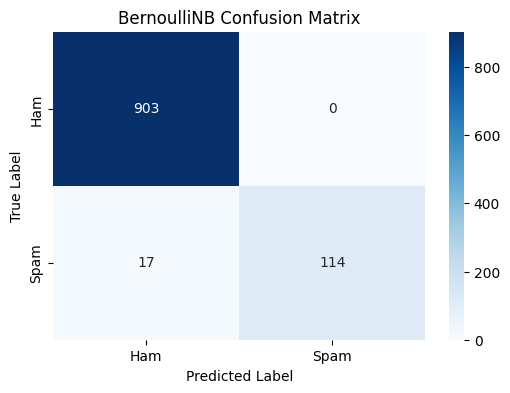

In [53]:
# Bernoulli Naive Bayes
bnb=BernoulliNB()
bnb.fit(X_train_text,y_train)
evaluate_model(bnb, X_test_text, y_test, "BernoulliNB")

C:\Users\adrij\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
Accuracy: 0.9739
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.96      0.82      0.89       131

    accuracy                           0.97      1034
   macro avg       0.97      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



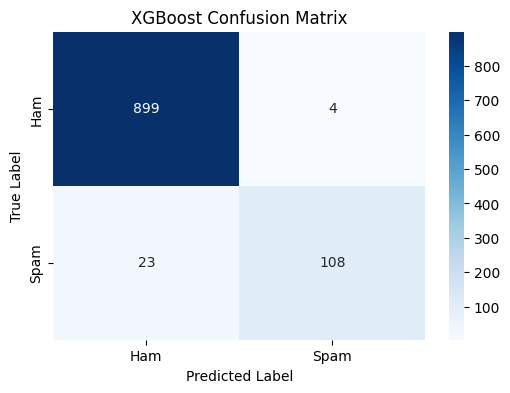

In [54]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    use_label_encoder=False
)
xgb.fit(X_train_text, y_train)
evaluate_model(xgb, X_test_text, y_test, "XGBoost")



Stacked Ensemble Performance:
Accuracy: 0.9787
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       903
           1       0.94      0.89      0.91       131

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



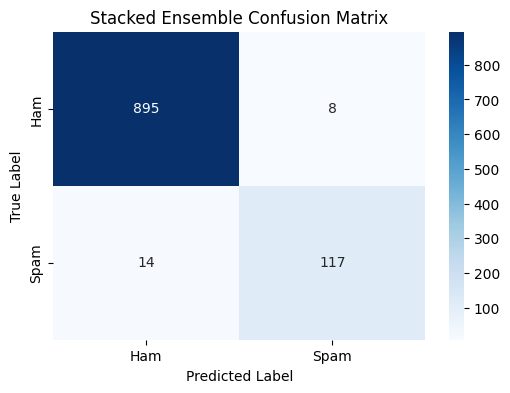

In [55]:
# Stacking Ensemble
estimators = [
    ('xgb', XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.05)),
    ('bnb', BernoulliNB(alpha=0.02))
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=0.5, max_iter=1000, class_weight='balanced'),
    stack_method='predict_proba'
)
stack.fit(X_train_text, y_train)
evaluate_model(stack, X_test_text, y_test, "Stacked Ensemble")

# So we see that Bernoulli Naive Bayes is our best model 

In [56]:
import pickle
# After training your TF-IDF and BernoulliNB model:
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('bnb_model.pkl', 'wb') as f:
    pickle.dump(bnb, f)

In [58]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
